In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
import lightgbm

import numpy as np
import h5py
from scipy import stats

from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
import seaborn as sns

%matplotlib inline

In [3]:
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_ALL.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_ALL.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_ALL.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_ALL.txt"

In [4]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_event_data = file['event_data']
    h5_nhits = file['nhits']
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    
    event_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("{} events; up to {} hits per event; {} features per hit per event.".format(event_data.shape[0],
                                                                    event_data.shape[1], event_data.shape[2]))
    nhits = np.array(h5_nhits)
    positions0 = file['positions']
    positions0 = np.array(positions0)   #initial positions of simulated particles
    angles = file['angles']             #initial angles of simulated particles
    angles = np.array(angles)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
1759960 events; up to 300 hits per event; 8 features per hit per event.


In [5]:
npPositions0 = [positions0[i].flatten() for i in range(len(positions0))]

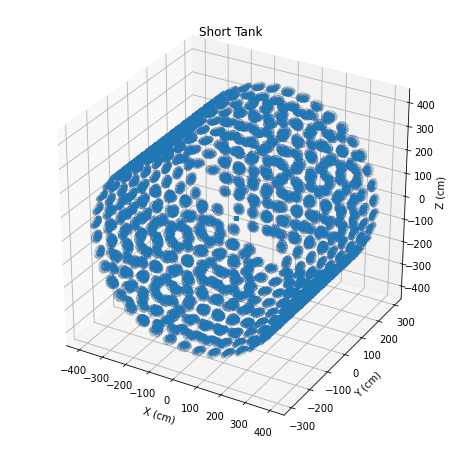

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=event_data[:, :, 2],
    ys=event_data[:, :, 3],
    zs=event_data[:, :, 4],
    alpha = 0.007,
)
#ax.set_title('Hit Locations of 16,000 events')
ax.set_title('Short Tank')
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

plt.show()

In [6]:
print('event 0....')
print('vertex: {}'.format(npPositions0[0]))
print('\nxPos: {}'.format(event_data[0, :, 2][:nhits[0]]))
print('yPos: {}'.format(event_data[0, :, 3][:nhits[0]]))
print('zPos: {}'.format(event_data[0, :, 4][:nhits[0]]))

event 0....
vertex: [-45.7129  180.73282  71.41624]

xPos: [ -16.653847 -381.33105  -305.21704   200.87633  -332.38693  -363.88382
  -44.80896   213.07939   234.16452  -342.59357    86.01878   287.06958
  268.0113    252.11409   -45.66896   381.5124    274.09085   362.855
  334.09302    93.30519   -27.08969  -363.88382  -338.71594  -287.06958
 -171.33267   195.50887    27.08969    85.59531   334.09302   143.27768
  152.75339  -392.59534  -386.61276   149.95422   361.14896  -164.45934
 -102.476776  247.85445   206.40285    31.415926 -308.54953    23.186934
  -45.66896  -205.65845  -161.40587    22.708237 -278.4171     38.859085
 -338.71594   -35.742165 -345.32843  -224.23772   -85.28202   346.32947
  151.7598    205.65845  -360.6742   -255.12064   363.88382   381.33105
 -200.87633   364.07608  -152.75339  -269.57043   292.65234  -159.09187 ]
yPos: [-6.8406769e+01  5.1171975e-15 -1.8485957e+02  4.5924744e+01
 -1.7230434e+02 -1.0610252e+02 -1.2858455e+02 -2.3638487e+02
 -2.9644907e+02 -1.

In [11]:
def mag(v):
    return np.linalg.norm(v)
    
def cosTheta(v, orig):
    return np.dot(v, orig) / (mag(v) * mag(orig))

In [12]:
import math
def theta(v, orig):
    cosT = cosTheta(v,orig)
    if abs(cosT) >= 1.00:
        return np.nan
    else:
        return math.acos(cosT) * (180/math.pi)

In [149]:
orig1 = np.array([0.1, 0, 0])
v1 = np.array([10, -2, -3])

In [150]:
print(theta(v1, orig1))

19.827028653408174


In [97]:
v = np.array([event_data[0,0,2], event_data[0,0,3],
                      event_data[0,0,4]])
print(v)

[-382.6846   232.05864   92.68303]


In [13]:
for x in range(9):
    print(theta(np.array([event_data[0,x,2], event_data[0,x,3],
                      event_data[0,x,4]]), npPositions0[0]))

119.72312192930247
72.13133785800646
91.06512305352773
108.51860743481234
90.11241148555926
83.83032287831438
126.34194112049846
146.06940070424307
138.73430411734847


__implement function__

In [14]:
def mean_opening_angle(event):
    angle = []
    orig = npPositions0[event]
    for hit in range(nhits[event]):
        v = np.array([event_data[event,hit,2], event_data[event,hit,3],
                      event_data[event,hit,4]])
        angle.append(theta(v, orig))
                
    return np.nanmean(angle)
    #return locations[nearest]

In [15]:
for i in range(7):
    #print(labels[i])
    print(mean_opening_angle(i))

110.65623687490643
42.08743307150015
73.69645435960835
107.58241242439654
63.42880933588099
39.89004034934813
85.57077877396245


In [129]:
idxNull = []
for x in range(len(npPositions0)):
#     print(x)
#     print(npPositions0[x])
    if mag(npPositions0[x]) == 0:
        idxNull.append(x)
    #tc.append(x[0])
    
# this says no vertex is exactly at the origin

In [136]:
idxNull = []
for event in range(event_data.shape[0]):
    if event%15000==0:
        print(event)
#     print(x)
#     print(npPositions0[x])
    for hit in range(nhits[event]):
        v = np.array([event_data[event,hit,2], event_data[event,hit,3],
                      event_data[event,hit,4]])
    
        if mag(v) == 0:
            idxNull.append([event, hit])
    #tc.append(x[0])
    
# this says no vertex is exactly at the origin

In [135]:
print(idxNull)

[]


In [156]:
neutron_moa = []
electron_moa = []
for x in range(event_data.shape[0]):
    if(x)%35000==0:
        print(x)
        
    if labels[x]==0:
        neutron_moa.append(mean_opening_angle(x)) 
    elif labels[x]==1:
        electron_moa.append(mean_opening_angle(x)) 

0
35000
70000
105000
140000
175000
210000
245000
280000
315000
350000
385000
420000
455000
490000
525000
560000
595000
630000
665000
700000
735000
770000
805000
840000
875000
910000
945000
980000
1015000
1050000
1085000
1120000
1155000
1190000
1225000
1260000
1295000
1330000
1365000
1400000
1435000
1470000
1505000
1540000
1575000
1610000
1645000
1680000
1715000
1750000


In [ ]:
print()

In [157]:
neutron_moa = np.array(neutron_moa)
electron_moa = np.array(electron_moa)

In [172]:
np.savetxt("/home/mattStubbs/watchmal/NeutronGNN/Kore/feature_engineering/MOA/moaE.csv", 
                  electron_moa)
np.savetxt("/home/mattStubbs/watchmal/NeutronGNN/Kore/feature_engineering/MOA/moaN.csv", 
                  neutron_moa)

In [158]:
print(stats.describe(neutron_moa))
print(stats.describe(electron_moa))

DescribeResult(nobs=834171, minmax=(2.1497513920427593, 144.45461352693098), mean=61.75274561533536, variance=397.5656586003152, skewness=0.27005932570742985, kurtosis=-0.3113884347976157)
DescribeResult(nobs=925789, minmax=(2.0955286559668047, 151.80441539866865), mean=60.732590304812696, variance=446.9921760598277, skewness=0.2900886903310947, kurtosis=-0.6438425169541615)


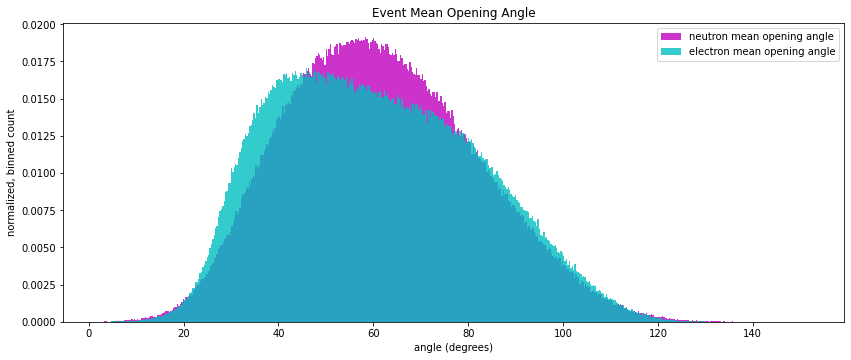

In [163]:
fig = plt.figure(figsize=(14,5.5))
nMOA = plt.hist(neutron_moa, color='m', bins=500, density = True, alpha=0.8, label='neutron mean opening angle')
eMOA = plt.hist(electron_moa, color='c', bins=500, density = True, alpha=0.8, label='electron mean opening angle')
plt.xlabel('angle (degrees)')
plt.ylabel('normalized, binned count')
plt.title('Event Mean Opening Angle')
plt.legend()
plt.savefig('mean opening angle', bbox_inches='tight', dpi=600 )
#print(histogram_intersection(nWallDist, eWallDist, bins=20))

In [160]:
import statistics
print(statistics.median(neutron_moa))
print(statistics.median(electron_moa))

60.54184693400082
59.05791923511736


In [168]:
moa = []
for x in range(event_data.shape[0]):
    if x%25000==0:
        print(x)
    moa.append(mean_opening_angle(x))

0
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000
450000
475000
500000
525000
550000
575000
600000
625000
650000
675000
700000
725000
750000
775000
800000
825000
850000
875000
900000
925000
950000
975000
1000000
1025000
1050000
1075000
1100000
1125000
1150000
1175000
1200000
1225000
1250000
1275000
1300000
1325000
1350000
1375000
1400000
1425000
1450000
1475000
1500000
1525000
1550000
1575000
1600000
1625000
1650000
1675000
1700000
1725000
1750000


In [169]:
moa = np.array(moa)

In [171]:
np.savetxt("/home/mattStubbs/watchmal/NeutronGNN/Kore/feature_engineering/MOA/moa.csv", 
                  moa)

__RMS angle__

In [17]:
def rms_opening_angle(event):
    angle = []
    rmsAng = []
    orig = npPositions0[event]
    countI = np.count_nonzero(event_data[event,:,1])
    
    for hit in range(nhits[event]):
        v = np.array([event_data[event,hit,2], event_data[event,hit,3],
                      event_data[event,hit,4]])
        angle.append(theta(v, orig))
                
    meanAng = np.nanmean(angle)
    
    return math.sqrt(np.sum((angle-meanAng)**2)/countI)

In [18]:
for x in range(5):
    print(rms_opening_angle(x))

30.7782772281636
32.7006837835379
39.311667447394896
33.57964249923548
41.642540776361464


In [22]:
neutron_rms_ang = []
electron_rms_ang = []
for x in range(event_data.shape[0]):
#for x in range(1000):
    if(x)%35000==0:
        print(x)
    if labels[x]==0:
        neutron_rms_ang.append(rms_opening_angle(x)) 
    elif labels[x]==1:
        electron_rms_ang.append(rms_opening_angle(x)) 

0
35000
70000
105000
140000
175000
210000
245000
280000
315000
350000
385000
420000
455000
490000
525000
560000
595000
630000
665000
700000
735000
770000
805000
840000
875000
910000
945000
980000
1015000
1050000
1085000
1120000
1155000
1190000
1225000
1260000
1295000
1330000
1365000
1400000
1435000
1470000
1505000
1540000
1575000
1610000
1645000
1680000
1715000
1750000


In [23]:
print(stats.describe(neutron_moa))
print(stats.describe(electron_moa))

NameError: name 'neutron_moa' is not defined

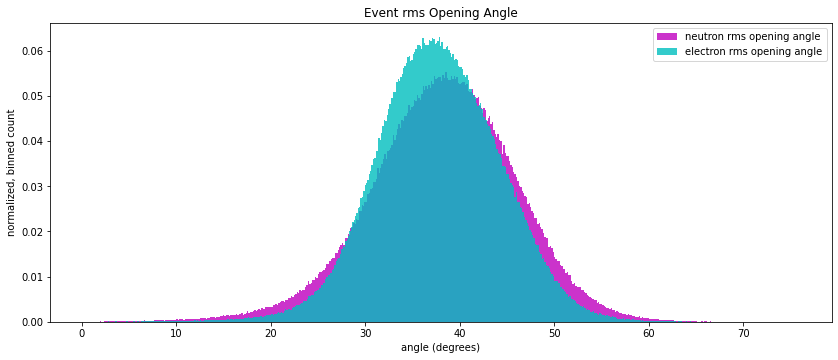

In [24]:
fig = plt.figure(figsize=(14,5.5))
neutron_ang_rms = plt.hist(neutron_rms_ang, color='m', bins=500, density = True, alpha=0.8, label='neutron rms opening angle')
electron_ang_rms = plt.hist(electron_rms_ang, color='c', bins=500, density = True, alpha=0.8, label='electron rms opening angle')
plt.xlabel('angle (degrees)')
plt.ylabel('normalized, binned count')
plt.title('Event rms Opening Angle')
plt.legend()
#plt.savefig('mean opening angle', bbox_inches='tight', dpi=600 )
#print(histogram_intersection(nWallDist, eWallDist, bins=20))